In [1]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Отлично, мы убедились, что при возможности вычисления будут проводится на GPU!



In [3]:
!pip install gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip uninstall -y Pillow==8.4.0
!pip install Pillow==5.3.0
import PIL
print(PIL.__version__)

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp39-cp39-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.3 requires pillow!=7.1.0,!=7.1.1,!=8.3.0,>=6.1.0, but you have pillow 5.3.0 which is incompatible.
matplotlib 3.7.1 requires pillow>=6.2.0, but you have pillow 5.3.0 which is incompatible.
imageio 2.25.1 requires pillow>=8.3.2, but you have pillow 5.3.0 which is incompatible.
fastai 2.7.12 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
dopamine-rl 4.0.6 requires Pillow>=7.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.4.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
5.3.0

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
!ls /content/gdrive/

MyDrive


In [7]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Apr 18 13:25 /content/gdrive/MyDrive/journey-springfield.zip


In [8]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
'''url = 'https://drive.google.com/file/d/1tHBy5bYUbSiJ9EzXgK7EvKK5D4mgXYaM/view?usp=share_link'
output = 'journey-springfield.zip'
gdown.download(url, output, quiet=False)'''

"url = 'https://drive.google.com/file/d/1tHBy5bYUbSiJ9EzXgK7EvKK5D4mgXYaM/view?usp=share_link'\noutput = 'journey-springfield.zip'\ngdown.download(url, output, quiet=False)"

In [9]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [ ]:
#!unzip -q journey-springfield.zip

In [10]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [11]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #20933
print(len(test_files))      #991

20933
991


In [12]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 18 14:12:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [13]:
from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [14]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.9/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [15]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files,test_size=0.25,stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.



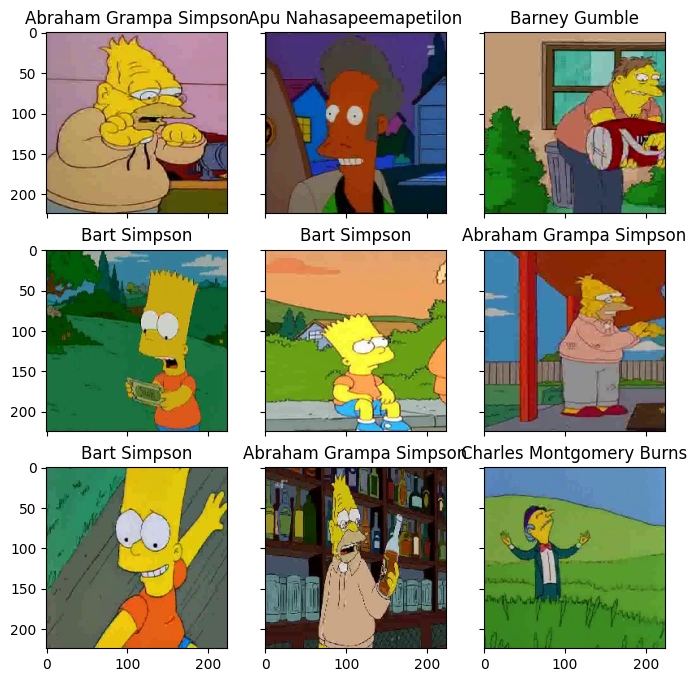

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [23]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),           
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) 
                
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)     

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [24]:
def fit_epoch(model, train_loader, optimizer, criterion):
    run_correct = 0 # Количество верных предсказаний, для подсчета лосса
    run_loss = 0 # куммулятивный лосс
    processed_data = 0 # общее число обработанных сэмплов, для подсчета лосса.(Напрямую из лоадера не вытащить?)
    model.train()
    for inputs, labels in train_loader:
        '''
        1. Перекинуть input, label на device.
        2. Обнулить градиент оптимизатора.
        3. Сделать предсказание.
        4. Подсчитать лосс
        5. backward-pass (вызывается в лоссе?)
        6. шаг оптимизатора
        7. Рассчитываем точность и лосс
        '''
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(output, 1)
        run_loss += loss.item() * inputs.size(0)
        #print(f"run_loss: {run_loss}, loss.item: {loss.item()}")
        run_correct += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = run_loss / processed_data
    train_acc = run_correct.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size # double()
    return val_loss, val_acc

In [26]:
def train(train_files, val_files, model, epochs, batch_size, sampler = None):
    if sampler is None:
        train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
    else:
        train_loader = DataLoader(train_files, batch_size = batch_size, sampler = sampler)
    val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

    history = []
    log_template = "\nEpoch: {ep:03d} train_loss: {t_loss:0.4f} train_accuracy: {t_acc:0.4f}\
    val_loss: {v_loss:0.4f} val_accuracy: {v_acc:0.4f}"

    with tqdm(desc = "epoch", total = epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion)
            print("loss", train_loss)
              
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history

In [27]:
def train(train_files, val_files, model, epochs, batch_size, sampler = None):
  if sampler is None:
    train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
  else:
    train_loader = DataLoader(train_files, batch_size = batch_size, sampler = sampler)
  val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

  history = []
  log_template = "\nEpoch: {ep:03d} train_loss: {t_loss:0.4f} train_accuracy: {t_acc:0.4f}\
  val_loss: {v_loss:0.4f} val_accuracy: {v_acc:0.4f}"

  with tqdm(desc = "epoch", total = epochs) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion)
      print("loss", train_loss)
            
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))
          
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                     v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      
  return history

In [28]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [29]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [30]:
DEVICE

device(type='cuda')

In [31]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [32]:
torch.cuda.empty_cache()

In [36]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=8)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.489103013105822


epoch:  17%|█▋        | 1/6 [01:12<06:04, 72.84s/it]


Epoch: 001 train_loss: 1.4891 train_accuracy: 0.5986  val_loss: 1.1975 val_accuracy: 0.6807
loss 1.0080632944438586


epoch:  33%|███▎      | 2/6 [02:24<04:47, 71.90s/it]


Epoch: 002 train_loss: 1.0081 train_accuracy: 0.7221  val_loss: 0.9462 val_accuracy: 0.7430
loss 0.7774292258753982


epoch:  50%|█████     | 3/6 [03:34<03:33, 71.26s/it]


Epoch: 003 train_loss: 0.7774 train_accuracy: 0.7796  val_loss: 0.8950 val_accuracy: 0.7633
loss 0.6191355076993003


epoch:  67%|██████▋   | 4/6 [04:44<02:21, 70.67s/it]


Epoch: 004 train_loss: 0.6191 train_accuracy: 0.8225  val_loss: 0.7870 val_accuracy: 0.7900
loss 0.4987768578086281


epoch:  83%|████████▎ | 5/6 [05:54<01:10, 70.30s/it]


Epoch: 005 train_loss: 0.4988 train_accuracy: 0.8559  val_loss: 0.7892 val_accuracy: 0.7959
loss 0.4138872268005728


epoch: 100%|██████████| 6/6 [07:02<00:00, 70.50s/it]


Epoch: 006 train_loss: 0.4139 train_accuracy: 0.8774  val_loss: 0.7394 val_accuracy: 0.8112


In [38]:
loss, acc, val_loss, val_acc = zip(*history)

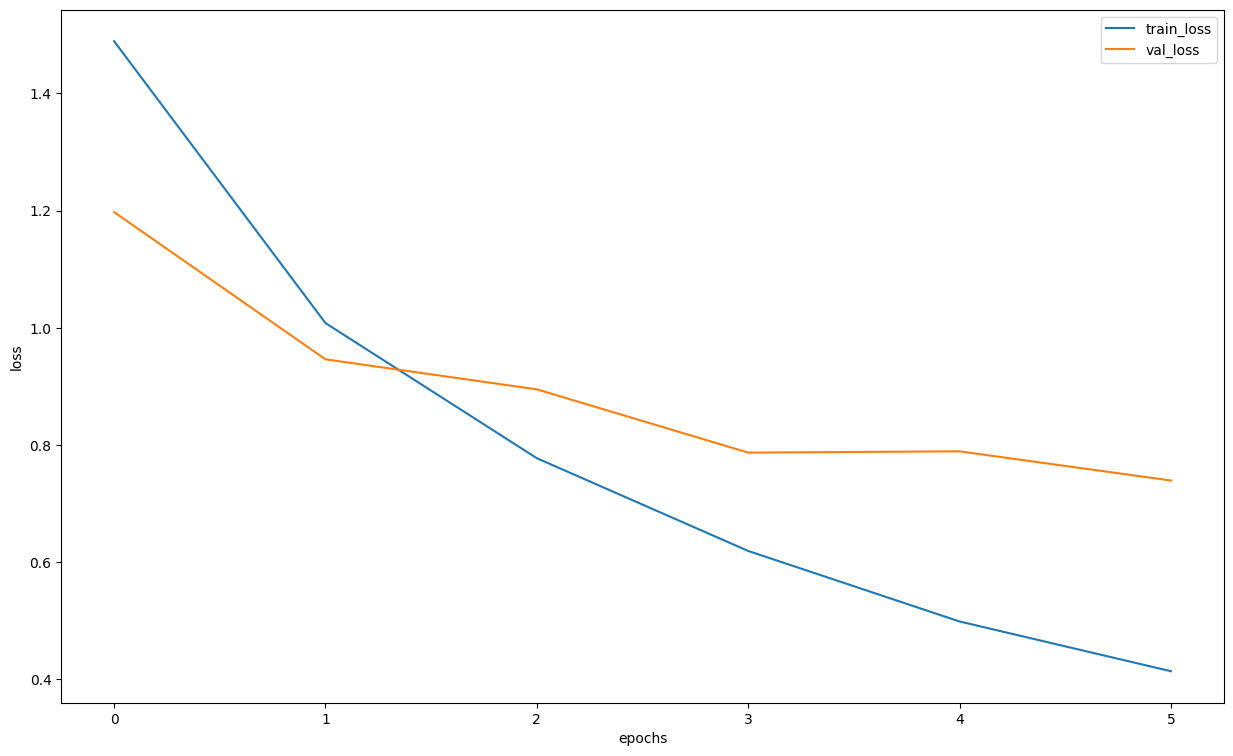

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [40]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))
transfer_model = models.alexnet(pretrained=True)
transfer_model
transfer_model.classifier = nn.Sequential(
            nn.Linear(9216, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, n_classes),
        )

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:10<00:00, 23.2MB/s]


In [41]:
transfer_model.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [42]:
history = train(train_dataset, val_dataset, model=transfer_model, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.3416931424006375


epoch:  12%|█▎        | 1/8 [01:19<09:18, 79.72s/it]


Epoch: 001 train_loss: 1.3417 train_accuracy: 0.6517  val_loss: 0.6762 val_accuracy: 0.8273
loss 0.4850139635764487


epoch:  25%|██▌       | 2/8 [02:45<08:21, 83.54s/it]


Epoch: 002 train_loss: 0.4850 train_accuracy: 0.8762  val_loss: 0.5426 val_accuracy: 0.8632
loss 0.2579983692331233


epoch:  38%|███▊      | 3/8 [04:03<06:44, 80.88s/it]


Epoch: 003 train_loss: 0.2580 train_accuracy: 0.9308  val_loss: 0.4709 val_accuracy: 0.8913
loss 0.17309947454456756


epoch:  50%|█████     | 4/8 [05:19<05:15, 78.94s/it]


Epoch: 004 train_loss: 0.1731 train_accuracy: 0.9534  val_loss: 0.3826 val_accuracy: 0.9091
loss 0.09980912181272979


epoch:  62%|██████▎   | 5/8 [06:36<03:54, 78.25s/it]


Epoch: 005 train_loss: 0.0998 train_accuracy: 0.9734  val_loss: 0.4566 val_accuracy: 0.9033
loss 0.09939779437918467


epoch:  75%|███████▌  | 6/8 [07:52<02:35, 77.59s/it]


Epoch: 006 train_loss: 0.0994 train_accuracy: 0.9722  val_loss: 0.4939 val_accuracy: 0.9008
loss 0.128870216685491


epoch:  88%|████████▊ | 7/8 [09:09<01:17, 77.38s/it]


Epoch: 007 train_loss: 0.1289 train_accuracy: 0.9664  val_loss: 0.6003 val_accuracy: 0.8796
loss 0.10580606584512117


epoch: 100%|██████████| 8/8 [10:24<00:00, 78.11s/it]


Epoch: 008 train_loss: 0.1058 train_accuracy: 0.9724  val_loss: 0.4276 val_accuracy: 0.9073


In [43]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [44]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [45]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [46]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [47]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [48]:
print(actual_labels)
print(preds_class)
print(y_pred)

[3, 4, 0, 0, 2, 6, 4, 5, 4, 0, 4, 4, 6, 2, 4, 6, 6, 0, 0, 0]
['nelson_muntz', 'bart_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'bart_simpson', 'carl_carlson', 'bart_simpson', 'lisa_simpson', 'bart_simpson', 'agnes_skinner', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'barney_gumble', 'abraham_grampa_simpson']
[29  4  0  0  2  6  4  5  4 20  4  1  6  2  4  6  6  0  3  0]


In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class)

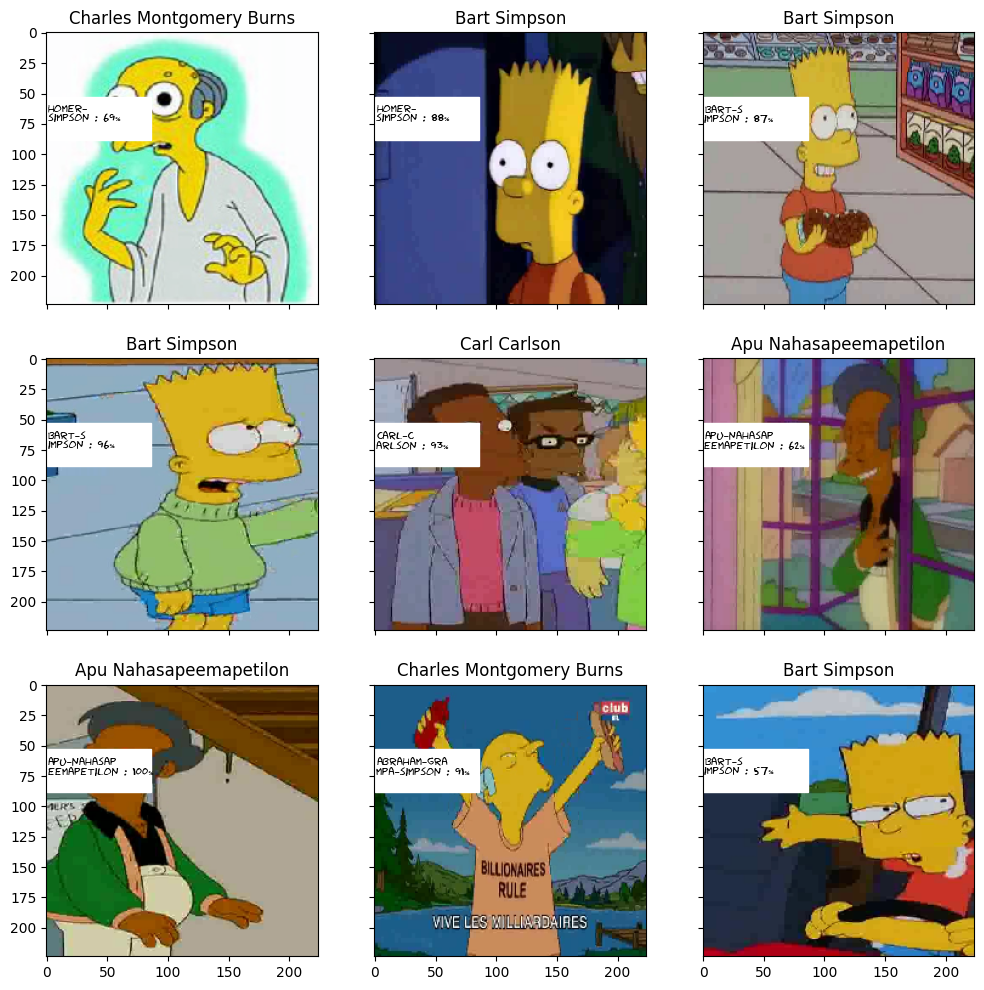

In [52]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [53]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(transfer_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [54]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [55]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)

In [59]:
import pandas as pd
my_submit = pd.DataFrame()
my_submit['Id'] = test_filenames
my_submit['Expected'] = preds
my_submit.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)

In [ ]:
#затычка чтобы не выкидывало из коллаба
x=int(5)
while x<10:
  x=5